## Table of contents
1. [Resizing](#Resizing-function)
2. [Preprocessing](#Preprocessing)
3. [Shape-Based Detection](#Shape-based-segmentation)
4. [Color-Based Detection](#Color-based-segmentation)
5. [Evaluation Functions](#Evaluation-functions)
6. [Main Function](#Main-function)
7. [Final Evaluation](#Final-evaluation)

In [4]:
# import all libraries
import sys
import cv2 as cv
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [5]:
# setup
assert sys.version_info >= (3, 8)

if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

In [6]:
# define functions to display images
def display_image(window_name, image):
    """ Display one image
    Arguments:
    ---
    window_name: str
    image: NumPy array
    adjust: fit the image to monitor size (boolean)
    
    Return:
    ---
    A window showing an image"""
    # if adjust:
    #     cv.namedWindow(window_name, cv.WINDOW_NORMAL)
    # else:
    #     cv.namedWindow(window_name)
    cv.imshow(window_name, image)
    cv.waitKey(0)
    cv.destroyAllWindows()

### Resizing

In [8]:
def resize_image(img, target_width=224):
    """
    Resizes the image to the target width while maintaining the aspect ratio.

    Args:
        img: The input image.
        target_width: The desired width for the resized image.

    Returns:
        The resized image and the scale factor.
    """
    # Get original dimensions
    original_height, original_width = img.shape[:2]
    
    # Calculate the scaling factor
    scale_factor = target_width / original_width
    
    # Calculate the new dimensions
    new_width = target_width
    new_height = int(original_height * scale_factor)
    
    # Resize the image
    img_resized = cv.resize(img, (new_width, new_height))
    
    return img_resized, scale_factor

### Preprocessing

In [10]:
def preprocess_image_for_shape_based(image):
    """
    Converts the input image to grayscale and applies Gaussian blur for preprocessing.

    Parameters:
    - image: The input BGR image.

    Returns:
    - blurred: The preprocessed grayscale and blurred image.
    """
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert to grayscale
    equalized = cv.equalizeHist(gray) # Apply histogram equalization
    blurred = cv.GaussianBlur(gray, (5, 5), 0)  # Apply Gaussian blur

    return blurred

In [11]:
def preprocess_image_for_color_based(img):
    """
    Preprocess an image by applying Gaussian blur and gamma correction.

    Parameters:
    -----------
    img : numpy.ndarray
        The input image

    Returns:
    --------
    numpy.ndarray
        The preprocessed image
    """
    
    # Apply Gaussian Blur to reduce noise
    image_preprocessed = cv.GaussianBlur(img, (5, 5), 0)

    # Apply Gamma Correction (adjusts the brightness and contrast)
    gamma = 0.8
    look_up_table = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)]).astype("uint8")
    image_preprocessed = cv.LUT(image_preprocessed, look_up_table)
    
    return image_preprocessed

### Shape-based segmentation

In [13]:
def detect_edges(image):
    """
    Detects edges in the input image using the Canny edge detection algorithm.

    Parameters:
    - image: The preprocessed grayscale image.

    Returns:
    - edges: The binary image showing detected edges.
    """
    edges = cv.Canny(image, 50, 150)  # Apply Canny edge detection
    
    return edges

def find_contours(edges):
    """
    Finds contours in the binary edge-detected image and returns an image with contours drawn.

    Parameters:
    - edges: The binary image resulting from edge detection.

    Returns:
    - contours_image: An image with contours drawn.
    - contours: A list of found contours.
    """
    # Find contours
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Create a blank image to draw contours
    contours_image = np.zeros_like(edges)  # Use the same size as the edges image

    # Draw all contours on the blank image
    cv.drawContours(contours_image, contours, -1, (255, 255, 255), 1)
    
    return contours_image, contours

def classify_shape(contour):
    """
    Classifies the shape of a contour based on its perimeter and the number of vertices.

    Parameters:
    - contour: A contour from the list of detected contours.

    Returns:
    - A string representing the identified shape ('Triangle', 'Square', 'Rectangle', 'Octagon', 'Circle', or 'Unknown').
    """
    perimeter = cv.arcLength(contour, True)  # Calculate the perimeter of the contour

    if perimeter == 0:  # To avoid division by zero in calculations
        return "Unknown"
    
    approx = cv.approxPolyDP(contour, 0.043 * perimeter, True)  
    # Approximate the contour shape to reduce the number of points

    if len(approx) == 3:
        return "Triangle"
    elif len(approx) == 4:
        x, y, w, h = cv.boundingRect(approx)  # Get the bounding box of the approximated contour
        aspect_ratio = float(w) / h  # Calculate the aspect ratio of the bounding box
        if 0.95 <= aspect_ratio <= 1.05:
            return "Square"
        else:
            return "Rectangle"
    elif len(approx) == 8:
        return "Octagon"
    else:
        area = cv.contourArea(contour)  # Calculate the area of the contour
        circularity = 4 * np.pi * (area / (perimeter * perimeter))  # Compute the circularity
        if 0.8 < circularity < 1.2:
            return "Circle"
    
    return "Unknown"

def filter_sign_contours(contours):
    """
    Filters contours to retain only those representing specific shapes.

    Parameters:
    - contours: A list of contours.

    Returns:
    - sign_contours: A list of contours with their shapes if they are among the specific shapes.
    """
    sign_contours = []
    for contour in contours:
        shape = classify_shape(contour)
        if shape in ["Triangle", "Square", "Rectangle", "Circle", "Octagon"]:
            sign_contours.append((contour, shape))
    return sign_contours

def get_largest_contour(contours):
    """
    Identifies the largest contour by area from a list of contours.

    Parameters:
    - contours: A list of contours.

    Returns:
    - largest_contour: The largest contour found (if any).
    - shape: The shape of the largest contour identified.
    """
    if not contours:
        return None, None
    return max(contours, key=lambda x: cv.contourArea(x[0]))

def segment_sign(image, contour):
    """
    Segments the area of the image corresponding to the detected contour.

    Parameters:
    - image: The original input image.
    - contour: The contour that outlines the area to be segmented.

    Returns:
    - segmented: The segmented portion of the image corresponding to the contour.
    """
    mask = np.zeros(image.shape[:2], dtype=np.uint8)  # Create a black mask with the size of the image
    cv.drawContours(mask, [contour], -1, 255, -1)  # Draw the contour on the mask in white
    segmented = cv.bitwise_and(image, image, mask=mask)  # Apply the mask to the image
    return segmented

def shape_process_image(image):
    """
    Processes the input image to detect and segment the largest contour, if any.

    Parameters:
    - image: The input image in BGR format.

    Returns:
    - edges: The binary image of detected edges.
    - contours_image: The image with contours drawn.
    - largest_contour: The largest contour detected (if any).
    - shape: The shape of the largest contour (if any).
    - segmented_sign: The segmented part of the image corresponding to the largest contour.
    """
    preprocessed_image = preprocess_image_for_shape_based(image)  # Preprocess the image
    edges = detect_edges(preprocessed_image)  # Detect edges in the preprocessed image
    contours_image, contours = find_contours(edges)  # Find contours from the edge-detected image
    sign_contours, sign_shapes = filter_sign_contours(contours)  # Filter relevant contours
    largest_contour, shape = get_largest_contour(sign_contours, sign_shapes)  # Identify the largest relevant contour
    
    if largest_contour is not None:
        segmented_sign = segment_sign(image, largest_contour)  # Segment the largest contour from the image
        return preprocessed_image, edges, contours_image, largest_contour, shape, segmented_sign  # Return results
    else:
        return preprocessed_image, edges, contours_image, None, None, None  # Return if no contour is found


### Color-based segmentation

In [15]:
def mask_image(image):
    """
    Create a mask for yellow, blue, and red colors in an image and apply it to the original image.

    Parameters:
    image (numpy.ndarray): Input image in BGR

    Returns:
    numpy.ndarray: Segmented image with only yellow, blue, and red colors visible.
                   All other colors are masked out (black).
    """

    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Define color ranges for yellow, blue, and red in HSV
    yellow_lower = np.array([19, 100, 100])
    yellow_upper = np.array([37, 255, 255])

    blue_lower = np.array([90, 100, 100])
    blue_upper = np.array([115, 255, 255])

    # Red wraps around the hue spectrum, so we need two ranges
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    # Create masks for each color
    yellow_mask = cv.inRange(hsv, yellow_lower, yellow_upper)
    blue_mask = cv.inRange(hsv, blue_lower, blue_upper)
    red_mask1 = cv.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv.bitwise_or(red_mask1, red_mask2)

    # Combine masks
    combined_mask = cv.bitwise_or(yellow_mask, blue_mask)
    combined_mask = cv.bitwise_or(combined_mask, red_mask)

    # Apply the mask to the original image
    result = cv.bitwise_and(image, image, mask=combined_mask)

    return result

In [16]:
def otsu_thresh(masked_image):
    """
    Apply Otsu's thresholding to the v channel of image.

    This function takes an image in BGR format, converts it to the HSV color space,
    and extracts the value (V) channel. Otsu's thresholding is then applied to this
    channel to create a binary thresholded image. The resulting binary image is
    converted back to a 3-channel BGR format and returned.

    Parameters:
    masked_image (numpy.ndarray): The input image in BGR format.

    Returns:
    numpy.ndarray: The thresholded image in BGR format.
    """
    # extract the value channel
    v_channel = cv.split(cv.cvtColor(masked_image, cv.COLOR_BGR2HSV))[2]

    # Apply otsu thresholding
    _, thresh = cv.threshold(v_channel, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

    # Convert output 2D image to 3D
    thresh = cv.cvtColor(thresh, cv.COLOR_GRAY2BGR)

    return thresh

In [17]:
def morphological_expansion(image, kernel_size=5, iterations=1):
    """
    Perform morphological expansion (dilation) on an image.

    Parameters:
    -----------
    image : numpy.ndarray
        The input image on which to apply morphological expansion.
    kernel_size : int, optional
        The size of the square structuring element (kernel) used for dilation. 
        Defaults to 5.
    iterations : int, optional
        The number of times the dilation operation is applied. 
        Defaults to 1.

    Returns:
    --------
    numpy.ndarray
        The image after morphological expansion, where the objects in the image 
        are expanded based on the kernel size and number of iterations.
    """
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (kernel_size, kernel_size))

    expanded_image = cv.morphologyEx(image, cv.MORPH_DILATE, kernel, iterations=iterations)

    return expanded_image

def morphological_erosion(image, kernel_size=5, iterations=1):
    """
    Perform morphological erosion on an image.

    Parameters:
    -----------
    image : numpy.ndarray
        The input image on which to apply morphological erosion.
    kernel_size : int, optional
        The size of the square structuring element (kernel) used for erosion. 
        Defaults to 5.
    iterations : int, optional
        The number of times the erosion operation is applied. 
        Defaults to 1.

    Returns:
    --------
    numpy.ndarray
        The image after morphological erosion, where the objects in the image 
        are eroded based on the kernel size and number of iterations.
    """

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (kernel_size, kernel_size))

    eroded_image = cv.morphologyEx(image, cv.MORPH_ERODE, kernel, iterations=iterations)

    return eroded_image

In [18]:
def get_contour(src_image):
    """
    Extract contours from an image and identify the longest contour.

    Parameters:
    -----------
    src_image : numpy.ndarray
        The input image from which to extract contours. The image should be in BGR format.

    Returns:
    --------
    tuple
        - contours (list of numpy.ndarray): A list of contours found in the image. Each contour is an array of points.
        - longest_contour (numpy.ndarray): The contour with the maximum area based on the contour's area. If no contours are found, returns None.
    """
    if len(src_image.shape) != 2:
        image_gray = cv.cvtColor(src_image, cv.COLOR_BGR2GRAY)
        
    else:
        image_gray = src_image

    # Find contours in the binary image
    contours = []
    contours, _ = cv.findContours(image_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return src_image, None
    # Find the longest contour based on arc length (perimeter)
    longest_contour = max(contours, key=cv.contourArea)

    return contours, longest_contour

In [19]:
def draw_contours(src, contours, longest=True):
    """
    Draw contours on a copy of the source image.

    Parameters:
    -----------
    src : numpy.ndarray
        The source image on which contours will be drawn.
    contours : list of numpy.ndarray
        A list of contours, where each contour is an array of points.
    longest : bool, optional
        If True, only the contour with the maximum area is drawn. If False, all contours in the list are drawn. Default=True.

    Returns:
    --------
    numpy.ndarray
        A copy of the source image with the specified contours drawn. If `longest` is True, only the contour with the maximum area is drawn
    """
    
    img_copy = src.copy()

    if longest:
        # Draw max contour
        longest_contour = max(contours, key=cv.contourArea)
        cv.drawContours(img_copy, [longest_contour], -1, (0, 255, 0), 2)
    else:
        # draw all contours
        cv.drawContours(img_copy, contours, -1, (0, 255, 0), 2)
    return img_copy

In [20]:
def create_mask_from_longest_contour(src, longest_contour):
    """
    Create a binary mask from the longest contour in an image.

    Parameters:
    -----------
    src : numpy.ndarray
        The input image used to define the mask's dimensions. It should be in BGR format.
    longest_contour : numpy.ndarray
        The contour used to create the mask. It is an array of points representing the longest contour.

    Returns:
    --------
    numpy.ndarray
        A binary mask
    """

    # Create a blank mask with the same dimensions as the input image
    mask = np.zeros_like(src)

    if longest_contour is not None:
        # Fill the longest contour on the mask
        cv.drawContours(mask, [longest_contour], -1, (255, 255, 255), thickness=cv.FILLED)
    
    return mask

In [21]:
def segment_image(src, mask):
    """
    Segment an image using a binary mask.

    Parameters:
    -----------
    src : numpy.ndarray
        The source image to be segmented.
    mask : numpy.ndarray
        A binary mask where the regions to be kept are non-zero, and the regions to be discarded are zero.

    Returns:
    --------
    segmented image (numpy.ndarray)
        
    """
    img_copy = src.copy()
    img_segmented = cv.bitwise_and(src, mask)
    
    return img_segmented

### Evaluation functions

In [23]:
# get ground truth bounding box coordinate
def ground_truth_bb(image_annot_dir, scale_factor, image_name):
    """
    Retrieve the ground truth bounding box coordinates from  annotation file

    Parameters:
    -----------
    image_annot_dir : str
        The directory path to the annotation file containing bounding box information.
    scale_factor : float
        The factor by which the images are resized
    image_name : str
        The name of the image file (including the extension) for which the bounding box coordinates are required.

    Returns:
    --------
    tuple
        A tuple containing the scaled bounding box coordinates in the form (x1, y1, x2, y2)
    """
    
    # check if the file directory exists
    if not (os.path.exists(image_annot_dir)):
        print("{} does not exist!".format(image_annot_dir))
        return None
    
    # read file
    inFile = open(image_annot_dir, 'r')
    found = False
    for annot in inFile:
        # example annot: image_1.png;103;90;19;12;88;78;0;
        annot_splited = annot.split(";")
        
        image_file_name = annot_splited[0]
        image_size = annot_splited[1:3]
        image_bb = annot_splited[3:7]
        image_class = annot_splited[7]

        if (image_name == image_file_name):
            new_coord = [int(coord) * scale_factor for coord in image_bb]
            new_coord = tuple(map(round, new_coord)) # round floating point to integers
            # print(image_name, new_coord)
            found = True
            return new_coord
            
    if not found:
        print("{} does not exist".format(image_name))
        return None

In [24]:
# plot ground truth bounding box
def plot_ground_truth(dst, coord):
    """
    Plot the ground truth bounding box on an image.

    Parameters:
    -----------
    dst : numpy.ndarray
        The input image on which the ground truth bounding box will be drawn.
    coord : tuple
        The coordinates of the ground truth bounding box in the form (x1, y1, x2, y2),
        where (x1, y1) represent the top-left corner and (x2, y2) represent the bottom-right corner.

    Returns:
    --------
    numpy.ndarray
        The image with the ground truth bounding box and label drawn.
    """
    
    img_copy = dst.copy()
    x1, y1, x2, y2 = coord
    cv.rectangle(img_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv.putText(img_copy, 'ground truth', (x1, y1-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv.LINE_AA)
    
    return img_copy

In [25]:
def draw_and_pred_bounding_box(dst, c):
    """
    Draw bounding box around a contour and add a prediction label to the image.

    Parameters:
    -----------
    dst (numpy.ndarray): The destination image on which the bounding box will be drawn.
    c (array-like): contour for which the bounding box will be computed.

    Returns:
    --------
        img_copy (numpy.ndarray): The image with the bounding box and label drawn.
        coord (tuple): coordinates of the bounding box (top-left corner and bottom-right corner)
    """
    
    (x, y, w, h) = cv.boundingRect(c)
    coord = (x, y, x + w, y + h)
    img_copy = dst.copy()
    cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv.putText(img_copy, 'predicted', (x, y+h+20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv.LINE_AA)
    
    return img_copy, coord

In [26]:
def calc_IOU(boxA, boxB):
    """
    Calculate the Intersection over Union of two bounding boxes
    
    Parameters:
    -----------
    boxA, boxB : tuple or list of four integers
        
    Returns:
    --------
    IOU (float)
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute intersection area
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute union area
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    unionArea = boxAArea + boxBArea - interArea

    # compute IOU
    iou = interArea / float(unionArea)

    return iou

In [27]:
def calc_dice(boxA, boxB):
    """
    Calculate the Dice coefficient between two bounding boxes.

    Parameters:
    -----------
    boxA, boxB : tuple
        A tuple representing the coordinates of the bounding box in the format (x1, y1, x2, y2).
        
    Returns:
    --------
    float
        The Dice coefficient, which measures the overlap between the two bounding boxes.
    """
    
    # Unpack coordinates
    x1_A, y1_A, x2_A, y2_A = boxA
    x1_B, y1_B, x2_B, y2_B = boxB
    
    # Calculate intersection
    x1_inter = max(x1_A, x1_B)
    y1_inter = max(y1_A, y1_B)
    x2_inter = min(x2_A, x2_B)
    y2_inter = min(y2_A, y2_B)
    
    # Check if there is an intersection
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    area_inter = inter_width * inter_height
    
    # Calculate areas of each box
    area_A = (x2_A - x1_A) * (y2_A - y1_A)
    area_B = (x2_B - x1_B) * (y2_B - y1_B)
    
    # Calculate Dice coefficient
    dice = (2 * area_inter) / (area_A + area_B)
    
    return dice

In [28]:
def add_caption(image, caption):
    """
    Add caption below an image.

    Parameters:
    - image: The input image to which a caption will be added.
    - caption: The text to be added as a caption.

    Returns:
    - caption_image: image with caption added below
    """
    # Ensure the image is in BGR format
    if len(image.shape) == 2:
        image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    
    h, w = image.shape[:2]
    # Create a new image with extra space for the caption
    caption_image = np.zeros((h + 30, w, 3), dtype=np.uint8)
    caption_image[:h, :w] = image  # Copy the input image to the new image

    # Add text caption
    cv.putText(caption_image, caption, (10, h + 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv.LINE_AA)

    return caption_image

### Main function

In [51]:
import time
# directory of text file that stores ground truth bouding box coordinates
image_annot_dir = "image_coordinates.txt"

# list to store the performance
image_list = []
IOU_list = []
DICE_list = []
detection_time_list = []
total_time_list = []

# loop through image_1.png to image_101.png
for i in range(1, 101):
    image_name = f"image_{i}.png"
    image_path = f'Samples of 100/Samples of 100/{image_name}'

    # Read the image
    img = cv.imread(image_path)

    # check if image is loaded
    if img is None:
        print(f"Image {image_path} not found.")
        continue
    start_time = time.time()
    img_resized, scale_factor = resize_image(img)

    # ===============================================
    # SHAPE
    # ===============================================
    
    preprocessed_image_shape = preprocess_image_for_shape_based(img_resized)  # Preprocess the image
    edges = detect_edges(preprocessed_image_shape)  # Detect edges in the preprocessed image
    contours_image, contours = find_contours(edges)  # Find contours from the edge-detected image
    sign_contours = filter_sign_contours(contours)  # Filter relevant contours
    largest_contour, shape = get_largest_contour(sign_contours)  # Identify the largest relevant contour
    
    largest_contour_image = img_resized.copy()
    
    if largest_contour is not None:
        cv.drawContours(largest_contour_image, [largest_contour], -1, (0, 255, 0), 2)
    
    shape_mask = create_mask_from_longest_contour(img_resized, largest_contour)
    shape_segmented_image = segment_image(img_resized, shape_mask)
    
    # ==================================================
    # COLOR
    # ==================================================

    preprocessed_image_color = preprocess_image_for_color_based(img_resized) # preprocess the image
    masked_image = mask_image(preprocessed_image_color) # create mask
    thresh = otsu_thresh(masked_image) # perform otsu thresholding
    
    # Apply morphological operations
    eroded_image = morphological_erosion(thresh, kernel_size=5)
    expanded_image = morphological_expansion(eroded_image, kernel_size=3)

    # find the longest contours and use it to segment the traffic sign 
    contours, longest_contour = get_contour(expanded_image)
    contour_image = draw_contours(expanded_image, contours)
    color_mask = create_mask_from_longest_contour(img_resized, longest_contour)
    color_segmented_image = segment_image(img_resized, color_mask)
    
    # ===========================================================
    # post-processing
    # ===========================================================
    
    # perform bitwise or operation on shape mask and color mask
    combined_mask = shape_mask | color_mask
    
    # retrive the largest contour
    final_contours, final_contour = get_contour(combined_mask)

    # create mask from longest contour
    final_mask = create_mask_from_longest_contour(img_resized, final_contour)

    # segment image
    combined_segmented_image = segment_image(img_resized, final_mask)
    
    # End timing for detection and segmentation
    end_detection_time = time.time()

    # =======================================
    # Evaluate performance
    # =======================================
    
    # get coordinates of predicted bounding box
    if(largest_contour is not None):
        bounding_box_image, coord = draw_and_pred_bounding_box(img_resized, final_contour)
    else:
        bounding_box_image = img_resized.copy()
    
    # get coordinates of ground truth
    ground_truth_coord = ground_truth_bb(image_annot_dir, scale_factor, image_name)
    bounding_box_image = plot_ground_truth(bounding_box_image, ground_truth_coord)

    # calculate performance metrics
    IOU = calc_IOU(coord, ground_truth_coord)
    DICE = calc_dice(coord, ground_truth_coord)
    
    end_total_time = time.time()
    
    # Calculate time
    detection_time = end_detection_time - start_time
    total_time = end_total_time - start_time

    # store the performance in list
    image_list.append(image_name)
    IOU_list.append(IOU)
    DICE_list.append(DICE)
    detection_time_list.append(detection_time)
    total_time_list.append(total_time)

    # ==================================================
    # formatting output display
    # ==================================================

    # placeholder to match shape for display
    placeholder_image = np.ones_like(img_resized)

    # Add captions
    placeholder_image_with_caption        = add_caption(placeholder_image, "Placeholder")
    image_with_caption                    = add_caption(img_resized, "Original")
    # ============================================================
    preprocessed_image_color_with_caption = add_caption(preprocessed_image_color, "Preprocessed (Color)")
    masked_image_with_caption             = add_caption(masked_image, "color mask")
    thresh_with_caption                   = add_caption(thresh, "threshold")
    morphed_image_with_caption            = add_caption(expanded_image, "morhped")
    contour_image_with_caption            = add_caption(contour_image, "Longest contour (color)")
    color_segmented_image_with_caption    = add_caption(color_segmented_image, "Color segmented")
    # ============================================================
    preprocessed_image_shape_with_caption = add_caption(preprocessed_image_shape, "Preprocessed (Shape)")
    edges_image_with_caption              = add_caption(edges, "Edge Detection")
    contours_image_with_caption           = add_caption(contours_image, "All Contours")
    largest_contour_image_with_caption    = add_caption(largest_contour_image, "Longest Contour (shape)")
    shape_segmented_image_with_caption    = add_caption(shape_segmented_image, "Shape segmented")
    # ===========================================================
    combined_segmented_image_with_caption = add_caption(combined_segmented_image, "Final Segmented Sign")
    bounding_box_image_with_caption       = add_caption(bounding_box_image, "Bounding Box")

    # =================================================
    # create ouput window for display
    # ================================================

    # combined color and shape
    result = np.hstack((image_with_caption,
                        color_segmented_image_with_caption,
                        shape_segmented_image_with_caption, 
                        combined_segmented_image_with_caption,
                        bounding_box_image_with_caption
                       ))
    
    # color
    color_row_1 = np.hstack((image_with_caption,
                             preprocessed_image_color_with_caption,
                             masked_image_with_caption, 
                             thresh_with_caption
                            ))
    
    color_row_2 = np.hstack((morphed_image_with_caption,
                             contour_image_with_caption,
                             color_segmented_image_with_caption,
                             placeholder_image_with_caption
                            ))

    color_result = np.vstack((color_row_1, color_row_2))

    # shape
    shape_row_1 = np.hstack((image_with_caption,
                             preprocessed_image_shape_with_caption,
                             edges_image_with_caption,
                            ))
    
    shape_row_2 = np.hstack((contours_image_with_caption,
                             largest_contour_image_with_caption,
                             shape_segmented_image_with_caption
                            ))

    shape_result = np.vstack((shape_row_1, shape_row_2))
    
    # ==================================================
    #            Display final results
    # ==================================================
    # modifiy to display the desired outputs
    
    display_image("image_{}".format(i), result) # display results for color and shape combined
    
    # display_image("image_{}".format(i), color_result) # display color pipeline in details

    # display_image("image_{}".format(i), shape_result) # display shape pipeline in details

    # ===================================================
    # Save all results on local machine
    # ===================================================
    # Saving the processed images for combined, shape-only, and color-only results into their respective directories.
    # The image is saved in three different locations:
    # - combined_results_path: Stores the image with both color and shape analysis results.
    # - shape_results_path: Stores the image with only shape analysis results.
    # - color_results_path: Stores the image with only color analysis results.

    # Define the output directories
    combined_results_dir = 'Color and Shape Results'
    color_results_dir = 'Color Results'
    shape_results_dir = 'Shape Results'

    # create output directories
    os.makedirs(combined_results_dir, exist_ok=True)
    os.makedirs(color_results_dir, exist_ok=True)
    os.makedirs(shape_results_dir, exist_ok=True)

    # save results
    combined_results_path = os.path.join(combined_results_dir, f'image_{i}.png')
    cv.imwrite(combined_results_path, result)
    
    shape_results_path = os.path.join(shape_results_dir, f'image_{i}.png')
    cv.imwrite(shape_results_path, shape_result)

    color_results_path = os.path.join(color_results_dir, f'image_{i}.png')
    cv.imwrite(color_results_path, color_result)

### Final evaluation
To evaluate the performance of the pipeline

In [53]:
# Create a dictionary from the lists
performance_metrics = {
    "img_name": image_list,
    "IOU"     : IOU_list,
    "DICE"    : DICE_list,
    "Detection and Segmentation Time": detection_time_list,
    "Total Time" : total_time_list
}

# Convert the dictionary to DataFrame
df = pd.DataFrame(performance_metrics)

# Display the DataFrame
pd.set_option('display.max_rows', None)
#df

In [55]:
# calculate the average IOU and average DICE coefficient
avg_IOU = df['IOU'].mean()
avg_DICE = df['DICE'].mean()
avg_detect = df['Detection and Segmentation Time'].mean()
avg_total= df['Total Time'].mean()

# Count the number of images that passed the IOU threshold of 0.5
IOU_passed = [IOU for IOU in IOU_list if IOU > 0.5]
num_passed = len(IOU_passed)

In [57]:
# print evaluation metrics
print("average IOU =", round(avg_IOU, 4))
print("average DICE =", round(avg_DICE, 4))
print("average detection and segmentation time =", round(avg_detect, 4))
print("average total time =", round(avg_total, 4))
print("number of images passed = {}/{}".format(num_passed, len(df['IOU'])))

average IOU = 0.9126
average DICE = 0.952
average detection and segmentation time = 0.0031
average total time = 0.0035
number of images passed = 100/100


In [59]:
# Find the indices where IOU is less than or equal to 0.5
failed_indices = df[df['IOU'] <= 0.5].index.tolist()

# Retrieve the corresponding image names using these indices
failed_img_names = df.loc[failed_indices, 'img_name'].tolist()

# Check if images have passed 0.5 IOU
if not failed_img_names:
    print("No images have failed the 0.5 IOU threshold.")
else:
    print(f"Images that failed the 0.5 IOU threshold: {failed_img_names}")

No images have failed the 0.5 IOU threshold.


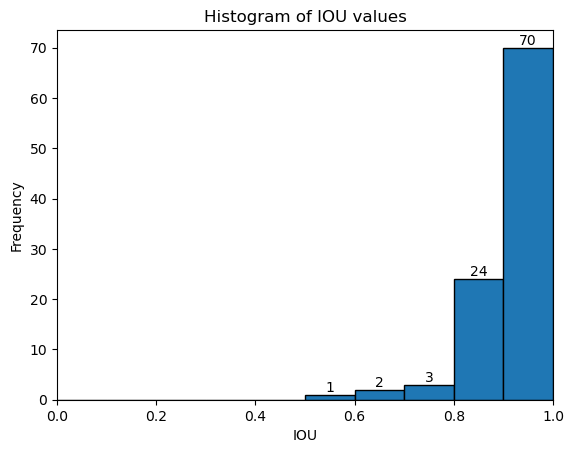

In [61]:
# Plot the histogram of IOU
plt.hist(df['IOU'], bins=np.linspace(0, 1, 11), edgecolor='black')
plt.title('Histogram of IOU values')
plt.xlabel('IOU')
plt.ylabel('Frequency')

# Get the values and bin edges
counts, bin_edges = np.histogram(df['IOU'], bins=np.linspace(0, 1, 11))

# Annotate each bar with the number of instances, if count is not zero
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(x + (bin_edges[1] - bin_edges[0]) / 2, count, str(count), ha='center', va='bottom')

plt.xlim([0, 1])
plt.show()


In [63]:
# display all columns
pd.set_option('display.max_columns', None)
print(df)

         img_name       IOU      DICE  Detection and Segmentation Time  \
0     image_1.png  0.798035  0.886969                         0.043054   
1     image_2.png  0.810100  0.894351                         0.003502   
2     image_3.png  0.850572  0.918656                         0.003137   
3     image_4.png  0.907920  0.951403                         0.003245   
4     image_5.png  0.833462  0.908552                         0.002911   
5     image_6.png  0.967892  0.983577                         0.002102   
6     image_7.png  0.947020  0.972603                         0.002273   
7     image_8.png  0.899822  0.946920                         0.003113   
8     image_9.png  0.831925  0.907600                         0.002949   
9    image_10.png  0.870147  0.930125                         0.003093   
10   image_11.png  0.916667  0.956268                         0.002006   
11   image_12.png  0.929293  0.963104                         0.001977   
12   image_13.png  0.882821  0.937373 

In [65]:
# print the statistics of segmentation results
df.describe()

,IOU,DICE,Detection and Segmentation Time,Total Time
count,100.000000,100.000000,100.000000,100.000000
mean,0.912560,0.951985,0.003072,0.003513
std,0.078460,0.048837,0.004087,0.004253
min,0.523460,0.684234,0.000997,0.001959
25%,0.893528,0.943369,0.002080,0.002610
50%,0.931885,0.964514,0.002830,0.003059
75%,0.962725,0.980868,0.003082,0.003558
max,0.992908,0.996416,0.043054,0.045070
